# Basic Chemostat Model

#TODO add schematic of chemostat model
#from IPython.display import Image
#Image(filename=('NPZDslab_schematics.png'), width=500)

In [1]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '../src/'))

Import necessary packages:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import xso
import phydra

Import the XSO model object:

In [3]:
from phydra.models import NPChemostat

In [4]:
# We can find out more about the model object by simply calling it:
NPChemostat

<xsimlab.Model (9 processes, 16 inputs)>
Core
    solver_type       [in] solver type to use for model
Time
    time              [in] ('input_time',) sequence of time points ...
Nutrient
    value_label       [in] label / nutrient concentration
    value_init        [in] initial value / nutrient concentration
Phytoplankton
    value_label       [in] label / phytoplankton concentration
    value_init        [in] initial value / phytoplankton concentration
N0
    forcing_label     [in] label / external nutrient
    value             [in] parameter / constant value
Inflow
    sink              [in] label reference / 
    source            [in] label reference / 
    rate              [in] parameter / linear rate of inflow
Outflow
    var_list          [in] ('d',) label list / variables flowing out
    rate              [in] parameter / linear rate of outflow
Growth
    resource          [in] label reference / 
    consumer          [in] label reference / 
    halfsat           [in] parame

This shows that we have a Xarray-simlab model object (the underlying framework below XSO) with 9 processes and 16 inputs, that need to be provided at model setup.

Two of the processes are provided by the XSO backend:
- Core
- Time
  
These processes handle solving models based on differential equations. They are included with every model built using XSO.

The other processes are our XSO components, that are included in the model:
- Nutrient: defines the state variable for a nutrient
- Phytoplankton: defines the state variable for phytoplankton
- N0 

## Now we can setup the model with specific parameters
This utilizes the 'xso.setup' function provided by the XSO framework. The basic parameters that need to be supplied are:
- solver: currently two choices 'odeint' or 'stepwise'
- model: this argument takes the model to be setup
- time: a numpy array 

In [14]:
chemostat_setup = xso.setup(solver='stepwise', model=NPChemostat,
            time=np.arange(0,100, 0.1),
            input_vars={
                    # State variables
                    'Nutrient':{'value_label':'N','value_init':1.},
                    'Phytoplankton':{'value_label':'P','value_init':0.01},
                
                    # Flows:
                    'Inflow':{'source':'N0', 'rate':0.1, 'sink':'N'},
                    'Outflow':{'var_list':['N', 'P'], 'rate':0.1},
                
                    # Growth
                    'Growth':{'resource':'N', 'consumer':'P', 'halfsat':0.7},
                
                    # Forcings
                    'N0':{'forcing_label':'N0', 'value':1.}
            })

In [15]:
chemostat_setup #.reset_coords()

<xarray.Dataset>
Dimensions:                     (time: 1000, d: 2, input_time: 1000)
Coordinates:
  * time                        (time) float64 0.0 0.1 0.2 ... 99.7 99.8 99.9
Dimensions without coordinates: d, input_time
Data variables: (12/16)
    Nutrient__value_label       <U1 'N'
    Nutrient__value_init        float64 1.0
    Phytoplankton__value_label  <U1 'P'
    Phytoplankton__value_init   float64 0.01
    Inflow__source              <U2 'N0'
    Inflow__rate                float64 0.1
    ...                          ...
    Growth__consumer            <U1 'P'
    Growth__halfsat             float64 0.7
    N0__forcing_label           <U2 'N0'
    N0__value                   float64 1.0
    Core__solver_type           <U8 'stepwise'
    Time__time                  (input_time) float64 0.0 0.1 0.2 ... 99.8 99.9
Attributes:
    __xsimlab_output_vars__:  Nutrient__value,Phytoplankton__value,Inflow__in...

In [16]:
from xsimlab.monitoring import ProgressBar

In [17]:
with ProgressBar():
    chemostat_out = chemostat_setup.xsimlab.run(model=NPChemostat)

             0% | initialize 

In [18]:
chemostat_out

<xarray.Dataset>
Dimensions:                     (time: 1000, d: 2, input_time: 1000)
Coordinates:
  * time                        (time) float64 0.0 0.1 0.2 ... 99.7 99.8 99.9
Dimensions without coordinates: d, input_time
Data variables: (12/22)
    Core__solver_type           <U8 'stepwise'
    Growth__consumer            <U1 'P'
    Growth__halfsat             float64 0.7
    Growth__resource            <U1 'N'
    Growth__uptake_value        (time) float64 0.005882 0.005882 ... 0.09222
    Inflow__input_value         (time) float64 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1
    ...                          ...
    Outflow__rate               float64 0.1
    Outflow__var_list           (d) <U1 'N' 'P'
    Phytoplankton__value        (time) float64 0.01 0.01049 ... 0.9222 0.9222
    Phytoplankton__value_init   float64 0.01
    Phytoplankton__value_label  <U1 'P'
    Time__time                  (input_time) float64 0.0 0.1 0.2 ... 99.8 99.9

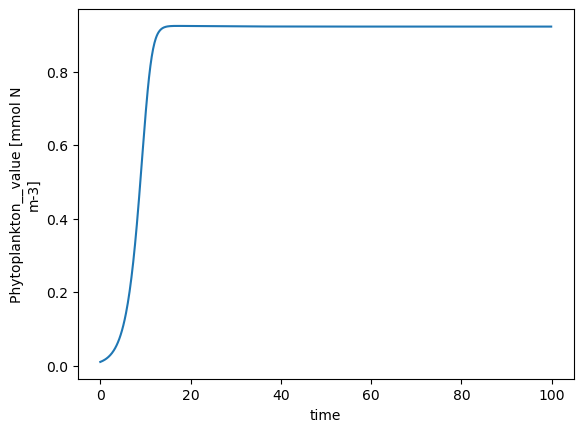

In [19]:
chemostat_out.Phytoplankton__value.plot(x='time')

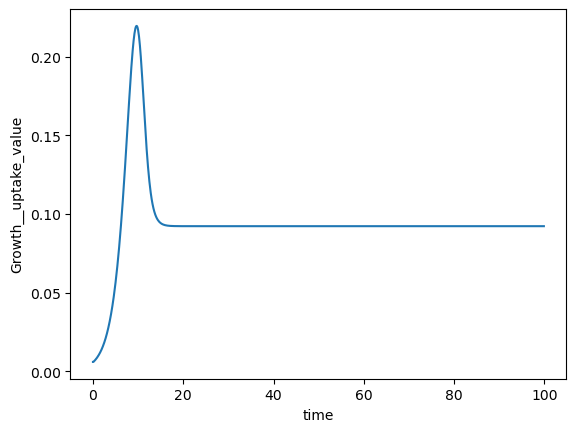

In [20]:
chemostat_out.Growth__uptake_value.plot()

In [21]:
## now add sinusoidal forcing:
from phydra.models.chemostat.forcings import SinusoidalExternalNutrient

NPChemostat_sinu = NPChemostat.update_processes({'N0':SinusoidalExternalNutrient})

with NPChemostat_sinu:
    chemostat_setup_sinu = chemostat_setup.xsimlab.update_vars(input_vars={'N0':{'forcing_label':'N0', 'period':24}})
    chemostat_out_sinu = chemostat_setup_sinu.xsimlab.run()

(0.0, 1.3388869446296894)

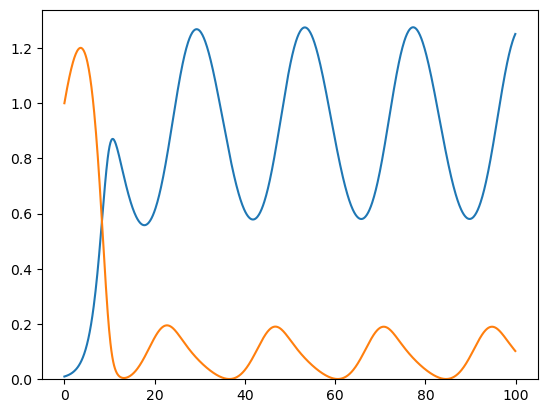

In [22]:
time = chemostat_out.Time__time
plt.plot(time, chemostat_out_sinu.Phytoplankton__value)
plt.plot(time, chemostat_out_sinu.Nutrient__value)
plt.ylim(bottom=0)

  adjustable: {'box', 'datalim'}
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  anchor: (float, float) or {'C', 'SW', 'S', 'SE', 'E', 'NE', ...}
  animated: bool
  aspect: {'auto', 'equal'} or float
  autoscale_on: bool
  autoscalex_on: unknown
  autoscaley_on: unknown
  axes_locator: Callable[[Axes, Renderer], Bbox]
  axisbelow: bool or 'line'
  box_aspect: float or None
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  facecolor or fc: color
  figure: `.Figure`
  frame_on: bool
  gid: str
  in_layout: bool
  label: object
  mouseover: bool
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  position: [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
  prop_cycle: unknown
  rasterization_zorder: float or None
  ras

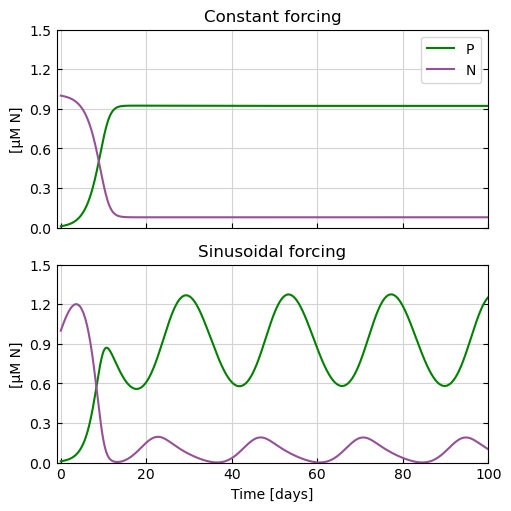

In [26]:
# Pub Plot Draft
%matplotlib inline

culr=['#955196','green','darkorange','brown']

plt.rcParams['figure.figsize'] = [5, 5]

numcols = 1
f1, ax1 = plt.subplots(2, numcols, sharex='col', constrained_layout=True)  #, sharey='row')

plt.setp((ax1, ))  # , xticks=[1,60,120,180,240,300,365]
from matplotlib.ticker import MaxNLocator
for axe in (ax1,):
    for i in range(2):
        
        axe[i].grid(True, color='lightgrey')
        axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=5))
        axe[i].tick_params(top=False, right=True, direction="in")

time = chemostat_out.Time__time
ax1[0].set_title('Constant forcing')
#ax1[0].annotate('Monod',xy=(0, 0.6),rotation=90,xytext=(-30,.75), size='x-large', verticalalignment='center')
ax1[0].plot(time, chemostat_out.Phytoplankton__value, label='P', c=culr[1])
ax1[0].plot(time, chemostat_out.Nutrient__value, label='N', c=culr[0])
ax1[0].set_ylabel('[µM N]')

time = chemostat_out_sinu.Time__time
ax1[1].set_title('Sinusoidal forcing')
ax1[1].plot(time, chemostat_out_sinu.Phytoplankton__value, label='P', c=culr[1])
ax1[1].plot(time, chemostat_out_sinu.Nutrient__value, label='N', c=culr[0])


ax1[0].set_ylabel('[µM N]')
ax1[1].set_ylabel('[µM N]')

ax1[1].set_xlabel('Time [days]')


# Defining custom 'xlim' and 'ylim' values.
xlim = (-1, 100)

# Setting the values for all axes.
plt.setp((ax1,), xlim=xlim, ylim=(0,1.5))

f1.align_ylabels()

for axe in (ax1,):
    for i in range(1):
        axe[i].legend()#fontsize='small')

#ax1[1].set_yticklabels([])
#ax2[1].set_yticklabels([])
        
#plt.tight_layout()

#plt.subplots_adjust(hspace=0.1, wspace=0.1)

#plt.savefig('NP_Chemostat.pdf', bbox_inches='tight')
plt.show()